Taller 2. CDA

In [343]:
#librerías de manipulación
import pandas as pd
import numpy as np

#librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test
from sklearn.model_selection import train_test_split

# para la creación y evaluación de modelos linear y polinomial
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

##DESCARGA DE DATOS

In [344]:
# se reliza la descarga de mi github
df = pd.read_csv('https://raw.githubusercontent.com/foramirez50/CDA/main/Taller2/Data_Taller_2.csv',';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [345]:
df.head(5)

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt
0,1,1/01/2020,Springer,No,Mist + Cloudy,"8,175849","9,090375","0,805833","10,749882",331,654,985
1,2,2/01/2020,Springer,No,Mist + Cloudy,"9,083466","8,625733","0,696087","-16,652113",131,670,801
2,3,3/01/2020,Springer,No,Few clouds,"1,229108","0,902035","0,437273","16,636703",120,1229,1349
3,4,4/01/2020,Springer,No,Few clouds,"1,4","1,969734","0,590435","10,739832",108,1454,1562
4,5,5/01/2020,Springer,No,Partly cloudy,"2,666979","2,77569","0,436957","12,5223",82,1518,1600


In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   instant     731 non-null    int64 
 1   Date        731 non-null    object
 2   Season      731 non-null    object
 3   Holiday     731 non-null    object
 4   Weather     731 non-null    object
 5   Temp        727 non-null    object
 6   Feel_Temp   731 non-null    object
 7   Hum         731 non-null    object
 8   Wind        731 non-null    object
 9   Casual      731 non-null    int64 
 10  Registered  731 non-null    int64 
 11  cnt         731 non-null    int64 
dtypes: int64(4), object(8)
memory usage: 68.7+ KB


##1. LIMPIEZA Y PREPARACIÓN DE DATOS

In [347]:
#tenemos que cambiar las comas por puntos 
df = df.replace(",",".",regex=True)
# en el dataset hay sólo 1 fecha fuera de rango, la arreglamos con replace
df = df.replace("29/02/2021","01/03/2021",regex=True)
# encontramos 2 valores con  Partly    cloudy y  Partly cloudy, los remplazamos para que sea sólo 1
df = df.replace("Partly    cloudy","Partly cloudy",regex=True)

In [348]:
#llenando los campos en blanco con la media de la temperatura
df.fillna(15.27, inplace=True)

Antes de colocar la columna "Weather" como categorica, le tenemos que hacer algunos ajustes

In [349]:
df['Weather'] = df['Weather'].str.replace('+', '', regex=True)
df['Weather'] = df['Weather'].str.replace(' ', '', regex=True)

In [350]:
df['Weather'].unique()

array(['MistCloudy', 'Fewclouds', 'Partlycloudy', 'Clear', 'Mist',
       'MistBrokenclouds', 'MistFewclouds', 'RainThunderstorm',
       'LightRainScatteredclouds', 'Snow'], dtype=object)

In [351]:
# cambiamos los tipos de las columnas para que se ajusten a nuestro modelo
#las variables que categoricas las dejamos como categoricas
df['Date'] = pd.to_datetime(df['Date'])
df['Temp'] = df['Temp'].astype(float)
df['Feel_Temp'] = df['Feel_Temp'].astype(float)
df['Hum'] = df['Hum'].astype(float)
df['Wind'] = df['Wind'].astype(float)
df['Weather'] = df['Weather'].astype("category")
df['Holiday'] = df['Holiday'].astype("category")
df['Season'] = df['Season'].astype("category")

In [352]:
# Como la temperatura es una categoría numerica, me parece que se tiene que llenar con algo más que "0", por esto lleno los espacios en blanco con la media de Temp
df['Temp'].mean()

15.271057016142269

Se ve valores de humedad normalizada de 10, esta probabilidad sería demasiado pequeña y el valor de humedad sería muy alto, por esta razón se deduce que es un valor corrido una coma a la derecha

In [353]:
# se hace la función para corregir los valores errados
def hum_outliers(x):
  if x > 10:
    return(x/10)
  else:
    return(x)

df['Hum'] = df['Hum'].apply(hum_outliers)

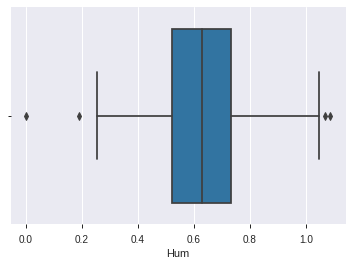

In [354]:
sns.boxplot(data=df, x="Hum")

In [355]:
print("Weather", df["Weather"].unique())

Weather ['MistCloudy', 'Fewclouds', 'Partlycloudy', 'Clear', 'Mist', 'MistBrokenclouds', 'MistFewclouds', 'RainThunderstorm', 'LightRainScatteredclouds', 'Snow']
Categories (10, object): ['Clear', 'Fewclouds', 'LightRainScatteredclouds', 'Mist', ...,
                          'MistFewclouds', 'Partlycloudy', 'RainThunderstorm', 'Snow']


Se agrupan las categorías como lo sugiere el especialista en el problema, un grupo para precipitaciones otro para neblina y otro para los demás estados

In [356]:
df["Weather"].replace(['MistCloudy', 'Fewclouds', 'Partlycloudy', 'Clear', 'Mist', 'MistBrokenclouds', 'MistFewclouds', 'RainThunderstorm', 'LightRainScatteredclouds', 'Snow'], [0,3,3,3,0,0,0,1,3,1], inplace=True)

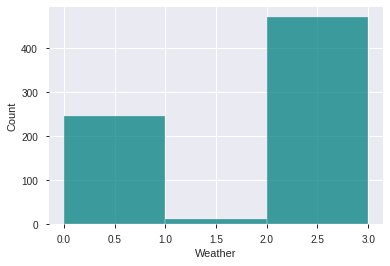

In [357]:
sns.histplot(data=df, x="Weather", color="teal", binwidth=1)

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   Date        731 non-null    datetime64[ns]
 2   Season      731 non-null    category      
 3   Holiday     731 non-null    category      
 4   Weather     731 non-null    int64         
 5   Temp        731 non-null    float64       
 6   Feel_Temp   731 non-null    float64       
 7   Hum         731 non-null    float64       
 8   Wind        731 non-null    float64       
 9   Casual      731 non-null    int64         
 10  Registered  731 non-null    int64         
 11  cnt         731 non-null    int64         
dtypes: category(2), datetime64[ns](1), float64(4), int64(5)
memory usage: 59.0 KB


Como el enunciado del problema dice que tenemos que saber si es un día entre semana o fines de semana vamos a recuperar los días


In [359]:
df['weekday'] = df['Date'].dt.weekday

In [360]:
# se hace la función para encontrar si es día de trabajo, fines de semana = 1 entre semana = 0 
def date_workingdays(x):
  if x >= 5:
    return(1)
  else:
    return(0)
df['weekday'] = df['weekday'].apply(date_workingdays)


In [361]:
df.head(5)

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,weekday
0,1,2020-01-01,Springer,No,0,8.175849,9.090375,0.805833,10.749882,331,654,985,0
1,2,2020-02-01,Springer,No,0,9.083466,8.625733,0.696087,-16.652113,131,670,801,1
2,3,2020-03-01,Springer,No,3,1.229108,0.902035,0.437273,16.636703,120,1229,1349,1
3,4,2020-04-01,Springer,No,3,1.400000,1.969734,0.590435,10.739832,108,1454,1562,0
4,5,2020-05-01,Springer,No,3,2.666979,2.775690,0.436957,12.522300,82,1518,1600,0


##2. ANÁLISIS DE DATOS
2.1 ANÁLISIS UNIVARIADO

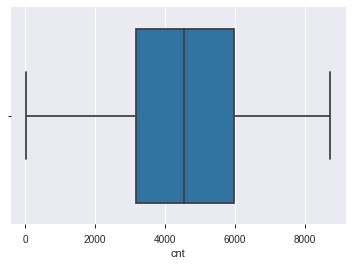

In [362]:
# se grafíca nuestra variable objetivo cnt
sns.boxplot(data=df, x="cnt")

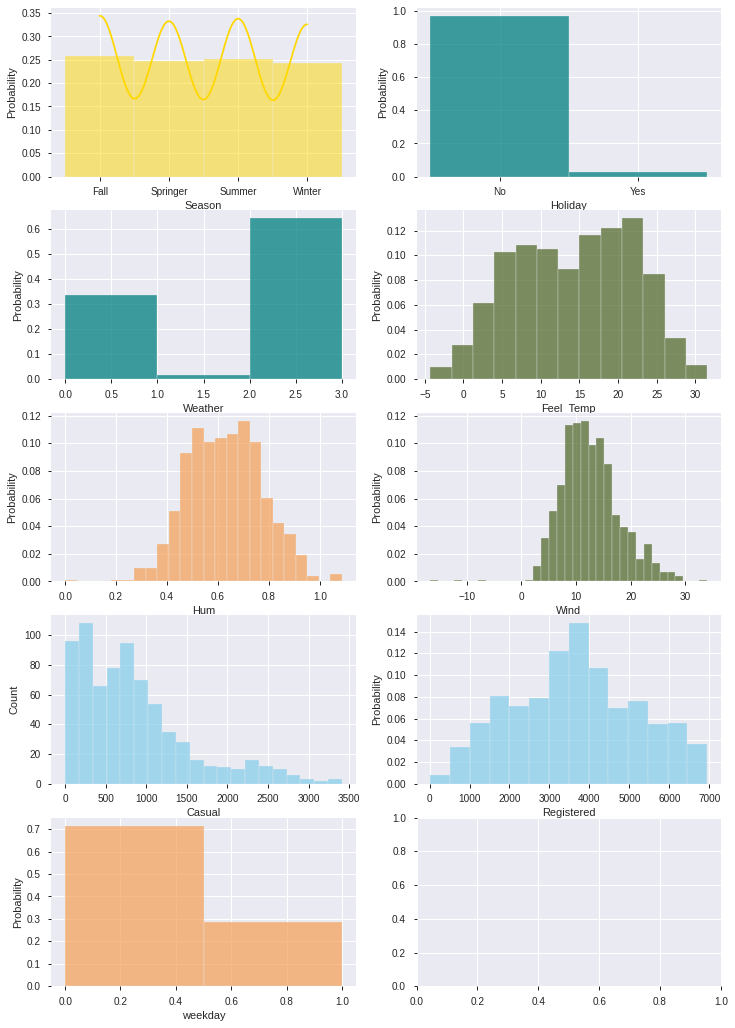

In [363]:
# Realizamos las gráficas univariadas y concluimos
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

sns.histplot(data=df, x="Season", kde=True, color="gold",stat='probability', binwidth=0.999, ax=axs[0, 0])
sns.histplot(data=df, x="Holiday", kde=False, color="teal",stat='probability', binwidth=0.5, ax=axs[0,1])
sns.histplot(data=df, x="Weather", kde=False, color="teal", stat='probability', binwidth=1, ax=axs[1, 0])
sns.histplot(data=df, x="Feel_Temp", kde=False, color="darkolivegreen", stat='probability', ax=axs[1,1])
sns.histplot(data=df, x="Hum", kde=False, color="sandybrown", stat='probability', ax=axs[2,0])
sns.histplot(data=df, x="Wind", kde=False, color="darkolivegreen", stat='probability', ax=axs[2,1])
sns.histplot(data=df, x="Casual",kde=False,  color="skyblue",  ax=axs[3, 0])
sns.histplot(data=df, x="Registered", kde=False, color="skyblue", stat='probability', ax=axs[3, 1])
sns.histplot(data=df, x="weekday", kde=False, color="sandybrown", stat='probability', binwidth=0.5, ax=axs[4, 0])
plt.show()

Conclusiones de análisis univariado

Balanceadas : Las estaciones están balanceadas, hay un desbalanceo en weekday y holiday, pero eso es propio del mas bajo número de estas fechas.

La variable Casual, está bien acostada hacia la derecha, eso significa que hay muchos días en donde la gente sale poco o no sale, los días en donde los usuarioso son muchos, son relamente reducidos

En cuanto al clima, la gente sale más cuando está en otros climas y el menor es cuando está lloviendo

El resto son distribuciones normales un poco acostadas a cada lado

2.2 ANÁLISIS BIRARIADO

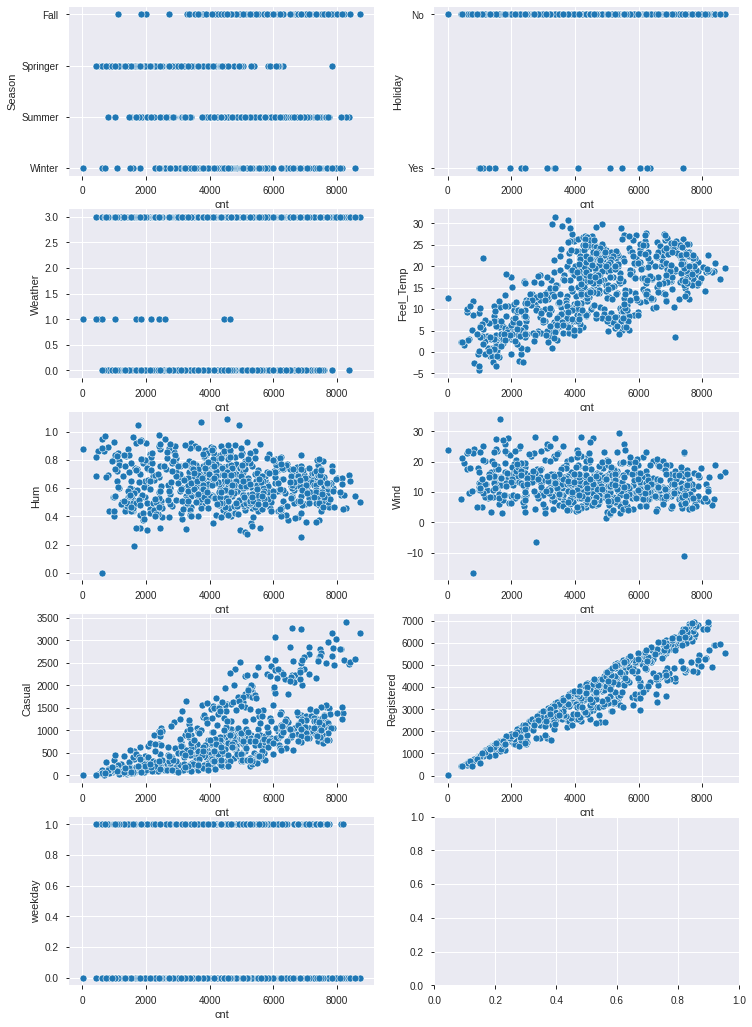

In [364]:
# Realizamos las gráficas univariadas y concluimos
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

sns.scatterplot(data=df, x="cnt", y = 'Season', ax=axs[0, 0])
sns.scatterplot(data=df, x="cnt", y = 'Holiday', ax=axs[0,1])
sns.scatterplot(data=df, x="cnt", y = 'Weather', ax=axs[1, 0])
sns.scatterplot(data=df, x="cnt", y = 'Feel_Temp', ax=axs[1,1])
sns.scatterplot(data=df, x="cnt", y = 'Hum', ax=axs[2,0])
sns.scatterplot(data=df, x="cnt", y = 'Wind', ax=axs[2,1])
sns.scatterplot(data=df, x="cnt", y = 'Casual',  ax=axs[3, 0])
sns.scatterplot(data=df, x="cnt", y = 'Registered', ax=axs[3, 1])
sns.scatterplot(data=df, x="cnt", y = 'weekday', ax=axs[4, 0])
plt.show()

Vemos una relación muy alta entre las variables predictoras Casual y Registered con la variable objetivo

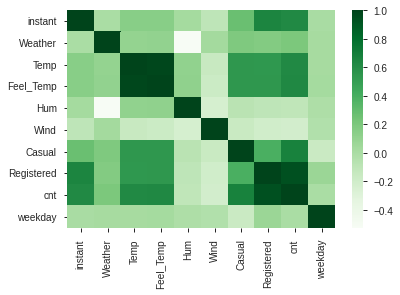

In [365]:
sns.heatmap(df.drop('Date', axis = 1).corr(), cmap = "Greens")

In [366]:
# se transforman a númericas las variables categoricas para ingresarlas a los modelos
df['Season'].replace(['Springer', 'Summer', 'Fall', 'Winter'], [0, 1, 2, 3], inplace=True)
df['Holiday'].replace(['No', 'Yes'], [0, 1], inplace=True)

In [367]:
# se verifica que no hayan quedado valores erroneos
print(df['Season'].unique())
print(df['Holiday'].unique())

[0 1 2 3]
[0 1]


In [368]:
df.head(10)

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,weekday
0,1,2020-01-01,0,0,0,8.175849,9.090375,0.805833,10.749882,331,654,985,0
1,2,2020-02-01,0,0,0,9.083466,8.625733,0.696087,-16.652113,131,670,801,1
2,3,2020-03-01,0,0,3,1.229108,0.902035,0.437273,16.636703,120,1229,1349,1
3,4,2020-04-01,0,0,3,1.400000,1.969734,0.590435,10.739832,108,1454,1562,0
4,5,2020-05-01,0,0,3,2.666979,2.775690,0.436957,12.522300,82,1518,1600,0
5,6,2020-06-01,0,0,3,1.604356,2.960823,0.518261,6.000868,88,1518,1606,0
6,7,2020-07-01,0,0,0,1.236534,1.815433,0.498696,11.304642,148,1362,1510,0
7,8,2020-08-01,0,0,0,-0.245000,-0.374062,0.535833,17.875868,68,891,959,1
8,9,2020-09-01,0,0,3,-1.498349,-2.539775,0.434167,24.250650,54,768,822,0
9,10,2020-10-01,0,0,3,-0.910849,-0.908264,0.482917,14.958889,41,1280,1321,0


In [369]:
#vemos que instant (el registro de los datos) no nos ofrece mucha información acerca de nuestro problema
# También vemos que Temp y Feel_Temp tienen mucha correlación
# También Registered y cnt tiene alta correlación, pero no los podemos eliminar, porque son vitales para el análisis
df.drop(['instant','Temp', 'Date'], axis=1, inplace=True)

In [370]:
df.head(5)

,Season,Holiday,Weather,Feel_Temp,Hum,Wind,Casual,Registered,cnt,weekday
0,0,0,0,9.090375,0.805833,10.749882,331,654,985,0
1,0,0,0,8.625733,0.696087,-16.652113,131,670,801,1
2,0,0,3,0.902035,0.437273,16.636703,120,1229,1349,1
3,0,0,3,1.969734,0.590435,10.739832,108,1454,1562,0
4,0,0,3,2.775690,0.436957,12.522300,82,1518,1600,0


In [371]:
# partimos los datos de entrenamiento y etiquetas
X = df.drop(['cnt'], axis=1)
Y = df['cnt']

In [372]:
# hacemos el split de test y train en un 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 33)
print('El xtrain es: {}'.format(X_train.shape))
print('El ytrain es: {}'.format(Y_train.shape))
print('El xtest es: {}'.format(X_test.shape))
print('El ytest es: {}'.format(Y_test.shape))

El xtrain es: (584, 9)
El ytrain es: (584,)
El xtest es: (147, 9)
El ytest es: (147,)


##3. EVALUACIÓN DE MODELOS
3.1 MODELO LINEAL

In [373]:
#  Se utilizó el standar escaler para que la media sea 0 y la desviación estandar 1
scaler = StandardScaler()

In [374]:
# se escaló el Y y X
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [375]:
# se nombró el modelo de una regresión lineal
linear_model = LinearRegression()

In [376]:
# se hace que el modelo se ajuste a los datasets de entrenamiento X y Y
linear_model.fit(X_train_scaled, Y_train)

LinearRegression()

In [377]:
# Se predice la variable objetivo con nuestro modelo
Y_preds_train = linear_model.predict(X_train_scaled)
Y_preds_test = linear_model.predict(X_test_scaled)

In [378]:
print('La media absoluta en el entrenamiento es: {}'.format(mean_absolute_error(Y_train, Y_preds_train)))
print('La media absoluta en el test es: {}'.format(mean_absolute_error(Y_test, Y_preds_test)))
print('R2 Prueba: {}'.format(r2_score(Y_test, Y_preds_test)))

La media absoluta en el entrenamiento es: 1.6110826523700245e-12
La media absoluta en el test es: 1.624097681737372e-12
R2 Prueba: 1.0


CONCLUSIÓN: En esta parte llama la atención el error tan bajo de predicción tanto con el test como el train. 

También el R2 igual a 1, significa que las variables predictoras son de mucha ayuda para predecir la variable objetivo casi de forma casi perfecta

3.2 MODELO POLINOMIAL

In [379]:
# se nombra los modelos polinomiales de grado 2 y 3
poly_model2 = PolynomialFeatures(degree=2, include_bias=False)
poly_X2 = poly_model2.fit_transform(X)
poly_model3 = PolynomialFeatures(degree=3, include_bias=False)
poly_X3 = poly_model3.fit_transform(X)

In [380]:
# hacemos el split test para cada modelo, teniendo en cuenta que si se hace en un grado inferior, no se podrían hacer las comparaciones con los Y
poly_X_train2, poly_X_test2, poly_Y_train2, poly_Y_test2 = train_test_split(poly_X2, Y, test_size = 0.2, random_state = 0)
poly_X_train3, poly_X_test3, poly_Y_train3, poly_Y_test3 = train_test_split(poly_X3, Y, test_size = 0.2, random_state = 0)

In [381]:
# se nombran los modelos
modelo_regresion_poly2 = LinearRegression()
modelo_regresion_poly3 = LinearRegression()

In [382]:
# se ajustan los modelos a los diferentes datos
modelo_regresion_poly2.fit(poly_X_train2, poly_Y_train2)
modelo_regresion_poly3.fit(poly_X_train3, poly_Y_train3)

LinearRegression()

In [383]:
# se hace la predicción de con los datos de entrenamiento
y_pred_train2 = modelo_regresion_poly2.predict(poly_X_train2)
y_pred_train3 = modelo_regresion_poly3.predict(poly_X_train3)

In [384]:
# se hace la predicción de con los datos de prueba
y_pred_test2 = modelo_regresion_poly2.predict(poly_X_test2)
y_pred_test3 = modelo_regresion_poly3.predict(poly_X_test3)

In [385]:
print('La media absoluta en el entrenamiento de un polinomio de grado 2 es: {}'.format(mean_absolute_error(poly_Y_train2, y_pred_train2)))
print('La media absoluta en el entrenamiento de un polinomio de grado 3 es: {}'.format(mean_absolute_error(poly_Y_train3, y_pred_train3)))
print('R2 Prueba con modelo polinomial de grado 2: {}'.format(r2_score(poly_Y_test2, y_pred_test2)))
print('R2 Prueba con modelo polinomial de grado 3: {}'.format(r2_score(poly_Y_test3, y_pred_test3)))

La media absoluta en el entrenamiento de un polinomio de grado 2 es: 4.0865180341610264e-11
La media absoluta en el entrenamiento de un polinomio de grado 3 es: 2.3629872364935135e-06
R2 Prueba con modelo polinomial de grado 2: 1.0
R2 Prueba con modelo polinomial de grado 3: 1.0


CONCLUSIONES: Como el error es más bajo en el grado 2, no se itera con más grados y se escoge este para hacer la regularización

3.3 MODELO CON REGULARIZACIÓN RIDGE

In [386]:
# se hace una regularización Ridge, se prueba con valores desde 0.2 hasta 0.005, la tabla se adjunta en las conclusiones
ridge_reg = Ridge(alpha=0.001,solver="cholesky")
ridge_reg.fit(poly_X_test2,poly_Y_test2)
ridge_2 = ridge_reg.predict(poly_X_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.08022e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [388]:
# se prueba el nuevo modelo con el test
poly_pred_ridge_test2 = ridge_reg.predict(poly_X_test2)
print('La media absoluta en el test de un polinomio de grado 2 con ridge alpha 0.001: {}'.format(mean_absolute_error(poly_Y_test2, poly_pred_ridge_test2)))
print('R2 Prueba con modelo polinomial de grado  con ridge alpha 0.001: {}'.format(r2_score(poly_Y_test2, poly_pred_ridge_test2)))

La media absoluta en el test de un polinomio de grado 2 con ridge alpha 0.001: 1.0267073163532234e-07
R2 Prueba con modelo polinomial de grado  con ridge alpha 0.001: 1.0


En este caso la regularización por Ridge no nos sirve para mejorar las predicciones, pues el error da más alto que sin la regularizacion.

COMPARANDO LOS MODELOS DE PREDICCIÓN.

Comparando esos modelos de regresión podemos decir que el mejor es el modelo lineal, pues ofrece el mejor desempeño en cuanto al error. 

El coeficiente R2 no se hace relevente en esta escogencia, pues en todos los modelos es igual a 1.

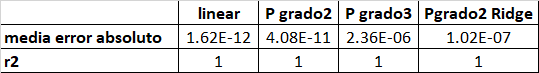

##4. INTERPRETACIÓN

● ¿Cuáles son las 3 variables más importantes para la predicción de la cantidad de usuarios?

Las variables predictoras que tiene más correlación con la variable objetivo, en orden sería Registered, Casual y Feel_Temp

● Describa cual es el escenario ideal para el incremento de usuarios.

De acuerdo con el análisis bivariado que se hizo, se llegan a las siguientes conclusiones

week day: Tiene que ser un día de trabajo 

season: preferiblemente en otoño, verano es caluroso y en primavera están de vacaciones.

Feel_Temp: tiene que estár en un rango de 15 a 20 grados celsius

Hum: la humedad normalizada tiene que estar entre 0.4 y 0.8

Wind: la velocidad del viento tiene que estar entre 0 y 20 m/s

● ¿Qué pasos adicionales deberían tener en cuenta para una próxima
iteración/mejora del modelo?

En vista que el modelo predice muy bien, las condiciones de clima en que la gente prefiere utilizar las bicicletas, el siguiente paso, para hacer una estrategia de marketing, sería recopilar más datos para hacer un modelo donde se intente hacer un tipo de user/persona para aumentar los usuarios de este medio de transporte.